In [2]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [1]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

Cloning into 'KRSPrediction'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 337 (delta 160), reused 145 (delta 50), pack-reused 0
Receiving objects: 100% (337/337), 6.63 MiB | 10.38 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [3]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [4]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [5]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [6]:
krs = krs.drop_duplicates(subset=["date"])

In [7]:
krs.shape

(3531, 9)

In [8]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [9]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3531 non-null   datetime64[ns]
 1   present_storage_tmc  3531 non-null   float64       
 2   inflow               3530 non-null   float64       
 3   outflow              3531 non-null   float64       
 4   max_temp             3531 non-null   float64       
 5   visibility           3531 non-null   float64       
 6   wind                 3531 non-null   float64       
 7   humidity             3531 non-null   float64       
 8   cloudcover           3531 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.9 KB


In [10]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [11]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [12]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [13]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [16]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [17]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [18]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


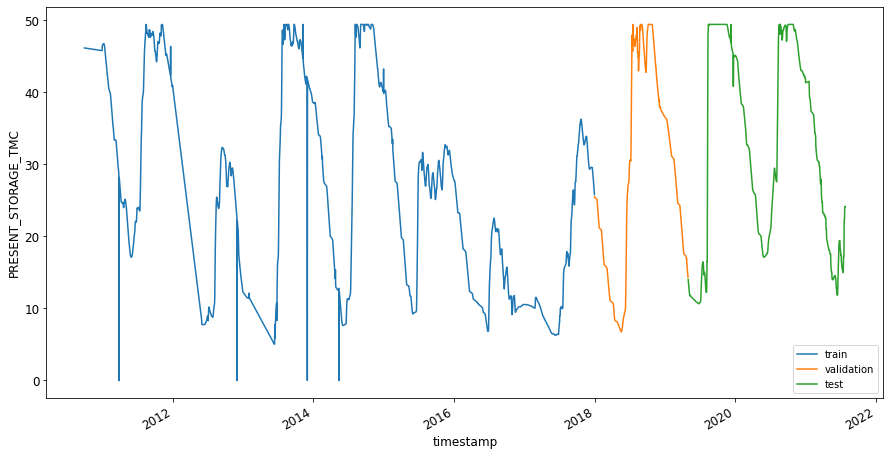

In [19]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [20]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [21]:
train.shape

(2250, 7)

In [22]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
flist = list(ts_data_load.columns)

In [24]:
T = 30
HORIZON = 30
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2014-04-15,0.367037,0.001928,0.046251,0.742991,0.650000,0.385764,0.115516
2017-03-29,0.198989,0.002756,0.012990,0.742991,0.816667,0.199766,0.112098
2012-08-22,0.499494,0.029966,0.052335,0.467290,0.633333,0.642209,0.088859
2011-02-14,0.795147,0.004107,0.040126,0.462617,0.700000,0.102665,0.069720
2017-05-01,0.156724,0.004002,0.008650,0.738318,0.700000,0.315026,0.088859
2016-06-29,0.139737,0.022276,0.014795,0.266355,0.516667,0.901435,0.153110
2016-09-22,0.282710,0.058350,0.002637,0.415888,0.783333,0.687170,0.150376
2017-02-18,0.205056,0.001624,0.002464,0.523364,0.683333,0.279145,0.164730
2012-09-30,0.631345,0.054987,0.059859,0.369159,0.550000,0.789836,0.076555


In [25]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [26]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-29, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [28]:
LATENT_DIM = T
BATCH_SIZE = 32
EPOCHS = (
    100
)

In [29]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [30]:
model.compile(optimizer="adam", loss="mse")


In [31]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 30)            3510      
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense (Dense)                (None, 30)                930       
Total params: 10,020
Trainable params: 10,020
Non-trainable params: 0
_________________________________________________________________


In [32]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [35]:
valid_inputs['X'].shape

(456, 30, 7)

In [34]:
ts_train_inp['X'].shape

(1864, 30, 7)

In [38]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
59/59 [==============================] - 6s 40ms/step - loss: 0.1274 - val_loss: 0.0234
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 3/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 5/100
59/59 [==============================] - 2s 30ms/step - loss: 0.0071 - val_loss: 0.0106
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0071 - val_loss: 0.0100
Epoch 7/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 8/100
59/59 [==============================] - 2s 27ms/step - loss: 0.0066 - val_loss: 0.0104
Epoch 9/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 10/100
59/59 [==============================] - 2s 29ms/step - loss: 0.0068 - val_loss: 0.0093

In [ ]:
model.save("30daysto30days")

INFO:tensorflow:Assets written to: 30daysto30days/assets


INFO:tensorflow:Assets written to: 30daysto30days/assets


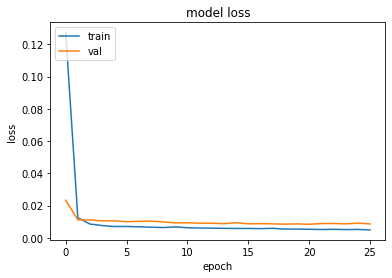

In [39]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
type(model_history.history['loss'])

list

In [43]:
min(model_history.history['loss']), min(model_history.history['val_loss'])

(0.004958732053637505, 0.008466809056699276)

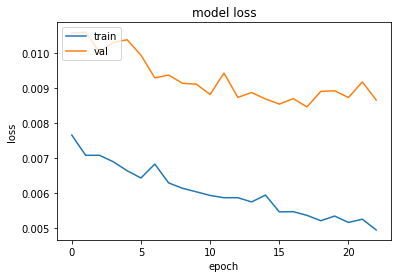

In [44]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [46]:
ts_data_test_inputs['X'].shape

(604, 30, 7)

In [47]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [48]:
ts_data_test_inputs["X"][0].shape

(30, 7)

In [51]:
ts_predictions[0].shape

(30,)

In [50]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(604, 31)         t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.227268  0.221517  0.236716  ...  0.307343  0.301779 2019-05-31
1  0.220263  0.219088  0.236803  ...  0.309139  0.304125 2019-06-01

[2 rows x 31 columns]
(18120, 3)    timestamp variable  prediction
0 2019-05-31      t+1    0.227268
1 2019-06-01      t+1    0.220263


,timestamp,variable,prediction,actual
9375,2020-09-11,t+16,47.913942,48.68
14154,2020-04-17,t+24,24.001117,20.18
5802,2020-11-01,t+10,47.192955,48.20
15296,2020-02-11,t+26,38.661093,32.54
3817,2020-02-08,t+7,39.640227,37.49


In [52]:
ts_predictions.shape

(604, 30)

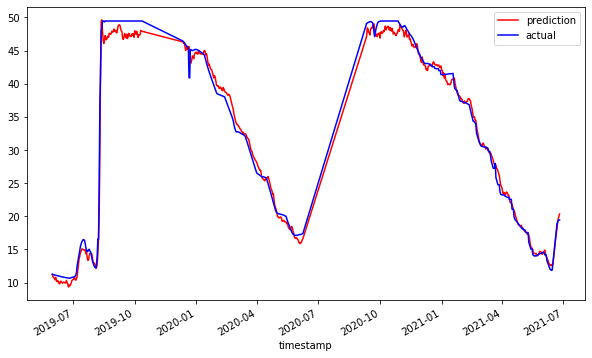

In [55]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [56]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.10153578091245179

In [ ]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [57]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [ ]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-05-31,t+1,11.571071,11.25,2019-06-01
1,2019-06-01,t+1,11.547426,11.22,2019-06-02


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#finetuning
T = 30
HORIZON = 30
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2017-01-07,0.213145,0.001562,0.001678,0.411215,0.095238,0.566804,0.020559
2020-09-25,0.965015,0.064344,0.038430,0.509346,0.152381,0.715462,0.096468


In [ ]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-26,0.488493,0.053957,0.015142,0.35514,1.0,0.650149,0.129151


In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=20,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    #callbacks=[earlystop],
    verbose=1,
)

Epoch 1/20
95/95 [==============================] - 3s 29ms/step - loss: 0.0076
Epoch 2/20
95/95 [==============================] - 2s 26ms/step - loss: 0.0059
Epoch 3/20
95/95 [==============================] - 2s 26ms/step - loss: 0.0059
Epoch 4/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0058
Epoch 5/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0059
Epoch 6/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0057
Epoch 7/20
95/95 [==============================] - 2s 26ms/step - loss: 0.0055
Epoch 8/20
95/95 [==============================] - 2s 26ms/step - loss: 0.0057
Epoch 9/20
95/95 [==============================] - 3s 28ms/step - loss: 0.0055
Epoch 10/20
95/95 [==============================] - 3s 29ms/step - loss: 0.0055
Epoch 11/20
95/95 [==============================] - 2s 25ms/step - loss: 0.0055
Epoch 12/20
95/95 [==============================] - 2s 26ms/step - loss: 0.0055
Epoch 13/20
95/95 [==================

In [ ]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(3039, 31)         t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.824298  0.830046  0.827133  ...  0.734018  0.721788 2011-01-29
1  0.820767  0.826068  0.822719  ...  0.732012  0.719870 2011-01-30

[2 rows x 31 columns]
(91170, 3)    timestamp variable  prediction
0 2011-01-29      t+1    0.824298
1 2011-01-30      t+1    0.820767


,timestamp,variable,prediction,actual
49669,2015-08-10,t+17,27.284268,26.940
42873,2012-08-13,t+15,28.949367,23.880
40699,2016-01-04,t+14,23.808333,24.350
38754,2019-01-02,t+13,33.051115,35.510
2860,2020-12-30,t+1,41.871408,41.965


In [ ]:
model.save("30daysto30days")

INFO:tensorflow:Assets written to: 30daysto30days/assets


INFO:tensorflow:Assets written to: 30daysto30days/assets


In [ ]:
cp -r '/content/30daysto30days/' '/content/gdrive/My Drive/Wave2web/'

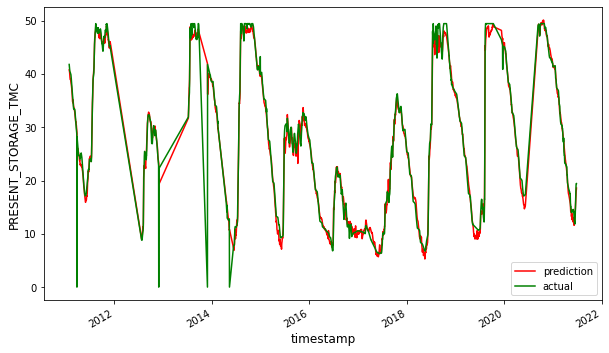

In [ ]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "g"], figsize=(10, 6)
)

plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()


In [ ]:
import datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [ ]:
ev_all_data.sample(20)

,timestamp,variable,prediction,actual,date
14155,2018-03-21,t+5,11.944420,11.000000,2018-03-26
49329,2014-09-04,t+17,49.271482,48.870000,2014-09-21
61892,2015-10-16,t+21,31.286324,29.930000,2015-11-06
78018,2018-05-04,t+26,12.987227,8.530000,2018-05-30
14569,2019-05-09,t+5,12.968958,11.800000,2019-05-14
39111,2020-02-23,t+13,33.027503,32.590000,2020-03-07
66794,2021-04-24,t+22,17.651978,15.064000,2021-05-16
25294,2015-06-08,t+9,9.172419,9.500000,2015-06-17
40487,2015-06-06,t+14,11.832105,9.630000,2015-06-20
46889,2016-04-25,t+16,9.872672,10.530000,2016-05-11


In [ ]:
ev_all_data.to_csv("predictions.csv")

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [ ]:
df = pd.read_csv("predictions.csv")

In [ ]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [ ]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [ ]:
conn.commit()

In [ ]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [ ]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)